<h2> Taller 11 - Control con Visión Artificial (parte 1)</h2>

<br>Requiere que los archivos 'sim.py', 'simConst.py', 'remoteapi.dll' estén alojados en la misma carpeta que este cuaderno de Jupyter.
<br> Desde CoppeliaSim, abrir la escena MTB_Vision.ttt


In [129]:
# importamos las librerías necesarias
import sim
import sympy as sp
import time

###  Conectamos con Sim y obtenemos los manejadores
Utilizamos las funciones del API Remoto de VREP.
<br> Para más detalles refiérase a la documentación de la librería:
<br> http://www.coppeliarobotics.com/helpFiles/en/remoteApiFunctionsPython.htm

In [130]:
def connect(port):
# Establece la conexión a CoppeliaSim
# port debe coincidir con el puerto de conexión en VREP
# retorna el número de cliente o -1 si no puede establecer conexión
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID


In [131]:
# Conectarse al servidor y obtener manejadores
def getHandlers():
    retCode,effector=sim.simxGetObjectHandle(clientID,'effector',sim.simx_opmode_blocking)
    retCode,target=sim.simxGetObjectHandle(clientID,'Cuboid',sim.simx_opmode_blocking)
    retCode,joint1=sim.simxGetObjectHandle(clientID,'MTB_joint1',sim.simx_opmode_blocking)
    retCode,joint2=sim.simxGetObjectHandle(clientID,'MTB_joint2',sim.simx_opmode_blocking)
    retCode,joint3=sim.simxGetObjectHandle(clientID,'MTB_joint3',sim.simx_opmode_blocking)
    retCode,joint4=sim.simxGetObjectHandle(clientID,'MTB_joint4',sim.simx_opmode_blocking)
    joint = [joint1, joint2, joint3, joint4]
    return joint, effector, target

In [132]:
def setEffector(val):
# acciona el efector final
# val es Int con valor 0 ó 1 para desactivar o activar el actuador final.
    res,retInts,retFloats,retStrings,retBuffer=sim.simxCallScriptFunction(clientID,
        "suctionPad", sim.sim_scripttype_childscript,"setEffector",[val],[],[],"", sim.simx_opmode_blocking)
    return res

In [133]:
# Definimos funciones para obtener matrices de transformación simbólicas

def symTfromDH(theta, d, a, alpha):
    # theta y alpha en radianes
    # d y a en metros
    Rz = sp.Matrix([[sp.cos(theta), -sp.sin(theta), 0, 0],
                   [sp.sin(theta), sp.cos(theta), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    tz = sp.Matrix([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, d],
                   [0, 0, 0, 1]])
    ta = sp.Matrix([[1, 0, 0, a],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    Rx = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    T = Rz*tz*ta*Rx
    return T

def matrixFromEuler(alpha, beta, gamma):
    # alpha, beta, gamma en radianes
    Ra = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    Rb = sp.Matrix([[sp.cos(beta), 0, sp.sin(beta), 0],
                   [0, 1, 0, 0],
                   [-sp.sin(beta), 0, sp.cos(beta), 0],
                   [0, 0, 0, 1]])
    Rc = sp.Matrix([[sp.cos(gamma), -sp.sin(gamma), 0, 0],
                   [sp.sin(gamma), sp.cos(gamma), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    T = Ra*Rb*Rc
    return T

def matrixFromPose(pose):
    # pose = [x, y, z, alpha, beta, gamma]
    # x, y, z en metros
    # alpha, beta, gamma en radianes
    x, y, z = pose[0], pose[1], pose[2]
    alpha, beta, gamma = pose[3], pose[4], pose[5]
    Ra = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    Rb = sp.Matrix([[sp.cos(beta), 0, sp.sin(beta), 0],
                   [0, 1, 0, 0],
                   [-sp.sin(beta), 0, sp.cos(beta), 0],
                   [0, 0, 0, 1]])
    Rc = sp.Matrix([[sp.cos(gamma), -sp.sin(gamma), 0, 0],
                   [sp.sin(gamma), sp.cos(gamma), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    T = Ra*Rb*Rc
    T[0,3] = x
    T[1,3] = y
    T[2,3] = z
    return T

<h3> 1. Obtenemos la cinemática directa</h3>
Conocidos los ángulos de las articulaciones, podemos conocer la posición final del actuador.

In [134]:
# Comenzaremos el trabajo desde la descripción de Denavit-Hartenberg para el robot
#      theta     |      d      |      a      |    alpha
# ---------------------------------------------------------
#      q1        |    0.302    |    0.467    |     0
#      q2        |    -0.01    |    0.4005   |    180
#      0         |      q3     |     0       |    180
#      q4        |      0      |     0       |     0
# ---------------------------------------------------------
#      0         |    -0.058   |     0       |     0

In [135]:
sq = sp.symbols(['q1','q2','q3','q4'])
T = sp.Matrix([[sp.cos(sq[0] + sq[1] + sq[3]), -sp.sin(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.cos(sq[0]) + 0.4005*sp.cos(sq[0] + sq[1])], 
               [sp.sin(sq[0] + sq[1] + sq[3]), sp.cos(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.sin(sq[0]) + 0.4005*sp.sin(sq[0]+ sq[1])], 
               [0, 0, 1, 0.234 - sq[2]], [0, 0, 0, 1]])
T

Matrix([
[cos(q1 + q2 + q4), -sin(q1 + q2 + q4), 0, 0.467*cos(q1) + 0.4005*cos(q1 + q2)],
[sin(q1 + q2 + q4),  cos(q1 + q2 + q4), 0, 0.467*sin(q1) + 0.4005*sin(q1 + q2)],
[                0,                  0, 1,                          0.234 - q3],
[                0,                  0, 0,                                   1]])

<h3> 2. Situamos el robot en un punto mediante cinemática inversa</h3>

In [136]:
# definimos las coordenadas de destino en la posición de reposo
pos = [0.8675, 0, 0.2335]
eul = [0, 0, 0]
pose_reposo = pos + eul
pose_reposo

[0.8675, 0, 0.2335, 0, 0, 0]

In [137]:
# definimos las coordenadas de destino en el centro de la cara superior de la caja
clientID = connect(19999)
joint, effector, target = getHandlers()
res, pos = sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_blocking)
res, eul = sim.simxGetObjectOrientation(clientID, target, -1, sim.simx_opmode_blocking)
a = pos[0]
b = pos[1]
c = pos[2] + 0.03
pos = [a, b, c]
print(eul)
print(pos)
pose_caja = pos + eul
pose_caja

conectado a 19999
[1.1172183178587147e-09, -1.5396462771377628e-08, -1.0358795357677097e-14]
[0.6000000834465027, 0.3749997615814209, 0.05499992400407791]


[0.6000000834465027,
 0.3749997615814209,
 0.05499992400407791,
 1.1172183178587147e-09,
 -1.5396462771377628e-08,
 -1.0358795357677097e-14]

<h3> 3. Ahora usamos visión artificial...</h3>

In [138]:
# Obtenemos el manejador del sensor de visión
clientID = connect(19999)
joint, effector, target = getHandlers()
retCode,sensorHandle=sim.simxGetObjectHandle(clientID,'Vision_sensor',sim.simx_opmode_blocking)

conectado a 19999


In [139]:
# Obtenemos la imagen
retCode, resolution, image=sim.simxGetVisionSensorImage(clientID,sensorHandle,0,sim.simx_opmode_oneshot_wait)

In [140]:
len(image)

750000

In [141]:
# importamos nuevas librerías
import cv2                      # opencv
import matplotlib.pyplot as plt # pyplot
import numpy as np         

Para esta parte se recomienda consultar las siguientes referencias:
<br><br>
Sobre manejo de contornos en openCV:<br>
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html<br>

Sobre openCV y Jupyter Notebooks:<br>
https://medium.com/@mrdatainsight/how-to-use-opencv-imshow-in-a-jupyter-notebook-quick-tip-ce83fa32b5ad<br>


In [142]:
img = np.array(image, dtype=np.uint8)
img.resize([resolution[1],resolution[0],3])
print(resolution)

[500, 500]


In [143]:
#cv2.imshow('image', img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


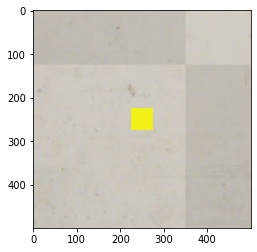

In [144]:
plt.imshow(img)
plt.show()

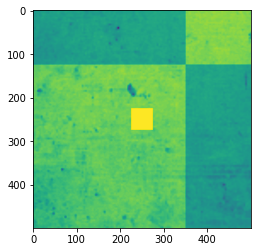

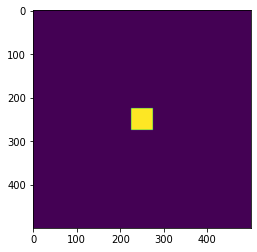

225
225
274
274
250.0 250.0


In [145]:
img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_GRAY = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
plt.imshow(img_GRAY)
plt.show()
ret , thresh = cv2.threshold(img_GRAY, 215, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)
plt.show()
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(contours[0][0][0][0][0])
print(contours[0][0][0][0][1])
print(contours[0][0][2][0][0])
print(contours[0][0][2][0][1])

cy = ((contours[0][0][2][0][1] + contours[0][0][0][0][1]) / 2)+0.5
cx = ((contours[0][0][0][0][0] + contours[0][0][2][0][0]) / 2)+0.5
print(cx, cy)

In [147]:

retCode,camera=sim.simxGetObjectHandle(clientID,'Vision-sensor',sim.simx_opmode_blocking)
res, posizioneCamera = sim.simxGetObjectPosition(clientID, camera, -1, sim.simx_opmode_blocking)
res, posizioneTarget = sim.simxGetObjectPosition(target, -1)
print("POSIZIONE CAMERA")
print(posizioneCamera)
print("POSIZIONE TARGET")
print(posizioneTarget)
xdiff = posizioneCamera[0] - posizioneTarget[0]
ydiff = posizioneCamera[1] - posizioneTarget[1]
print("diff from camera to target")
print(xdiff, ydiff)
immXdiff = ((resolution[0]/2) - cx) * 0.001
immYdiff = ((resolution[1]/2) - cy) * 0.001
print("diff calculated from the image")
print(immXdiff)
print(immYdiff)
#0.6500  e 0.3 sono la x e la y della camera nel mio sistema
posizioneTarget[0]=posizioneCamera[0] + immXdiff
posizioneTarget[1]=posizioneCamera[1] + immYdiff
posizioneTarget[2]=0.18
eulC=[0,0,0]
targetP = posizioneTarget + eulC
print(targetP)
sq2 = sp.symbols(['q1','q2','q3','q4'])
T2 = sp.Matrix([[sp.cos(sq[0] + sq[1] + sq[3]), -sp.sin(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.cos(sq[0]) + 0.4005*sp.cos(sq[0] + sq[1])], 
               [sp.sin(sq[0] + sq[1] + sq[3]), sp.cos(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.sin(sq[0]) + 0.4005*sp.sin(sq[0]+ sq[1])], 
               [0, 0, 1, 0.234 - sq[2]], [0, 0, 0, 1]])

# enviamos a la pose de destino
d2 = targetP
D2 = matrixFromPose(d2)
q2 = sp.nsolve(T2-D2, sq2, [0.1, 0.1, 0.1, 0.1], prec=6)
clientID = connect(19999)
joint, effector, target = getHandlers()
retCode = sim.simxSetJointTargetPosition(clientID, joint[0], q2[0], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint[1], q2[1], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint[2], q2[2], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint[3], q2[3], sim.simx_opmode_oneshot)
# Accionamos el actuador
setEffector(1)

# enviamos a la pose de reposo
#d = pose_reposo
#D = matrixFromPose(d)
#q = sp.nsolve(T-D, sq, [0.1, 0.1, 0.1, 0.1], prec=6)
#clientID = connect(19999)
#joint, effector, target = getHandlers()
#retCode = sim.simxSetJointTargetPosition(clientID, joint[0], q[0], sim.simx_opmode_oneshot)
#retCode = sim.simxSetJointTargetPosition(clientID, joint[1], q[1], sim.simx_opmode_oneshot)
#retCode = sim.simxSetJointTargetPosition(clientID, joint[2], q[2], sim.simx_opmode_oneshot)
#retCode = sim.simxSetJointTargetPosition(clientID, joint[3], q[3], sim.simx_opmode_oneshot)

TypeError: simxGetObjectPosition() missing 2 required positional arguments: 'relativeToObjectHandle' and 'operationMode'